# Mediation analyses on brain signatures 

## Load everything

In [68]:
from pingouin import mediation_analysis
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
base_dir = '~/projects/PIC_conditioning_withinsub_nodatalad'# adjust to you base dir
data = pd.read_csv(base_dir + '/signatures.csv')

# rank  transform nps_nociception_pain_wager_2011 and siips2_extranociceptive_pain_woo_2017
#data['nps_nociception_pain_wager_2011'] = data['nps_nociception_pain_wager_2011'].rank()
#data['siips2_extranociceptive_pain_woo_2017'] = data['siips2_extranociceptive_pain_woo_2017'].rank()

# Define variables
# convert x to categorical and get integer representation
data['Conditioning'] = data['Conditioning'].astype('category').cat.codes
data['Rating_diff'] = -1*data['Rating_diff']   # higher score stronger placebo
# center Age and Male
#data['Age'] = data['Age'] - data['Age'].mean()
#data['Male'] = data['Male'] - data['Male'].mean()

data.columns

Index(['Unnamed: 0', 'Study_ID', 'Sub_ID', 'Male', 'Age', 'NPS_pain_ctr',
       'Rating_pain_ctr', 'Rating_diff', 'Conditioning', 'TR', 'TE', 'FWHM',
       'Stim_Type', 'Stim_Dur', 'Stim_Side', 'Stim_Loc', 'Con_file',
       'nps_nociception_pain_wager_2011',
       'placebo_analgesia_anticip_wager_2011',
       'placebo_analgeisa_pain_wager_2011',
       'pines_negativeaffect_picture_chang_2015',
       'social_rejection_picture_woo_2014',
       'heartrate_social_threat_eisenbarth_2016',
       'skinconductance_social_threat_eisenbarth_2016',
       'vicarious_pain_picture_krishnan_2016',
       'empathy_care_listening_ashar_2017',
       'empathy_distress_listening_ashar_2017',
       'siips2_extranociceptive_pain_woo_2017',
       'pain_nociception_multistudy_kragel_2018',
       'negative_emotion_multistudy_kragel_2018',
       'cognitive_control_multistudy_kragel_2018',
       'threat_conditioning_acquisition_reddan_2018',
       'grbs_guilt_painresponsibility_yu_2019',
       

,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,nps_nociception_pain_wager_2011 ~ X,-0.004045,0.003291,0.219688,-0.010514,0.002424,No
1,Y ~ nps_nociception_pain_wager_2011,-90.812715,26.759972,0.000758,-143.418503,-38.206927,Yes
2,Total,2.194774,1.797240,0.222724,-1.338310,5.727858,No
3,Direct,1.834239,1.778649,0.303039,-1.662324,5.330801,No
4,Indirect,0.360535,0.344737,0.228000,-0.153452,1.277505,No


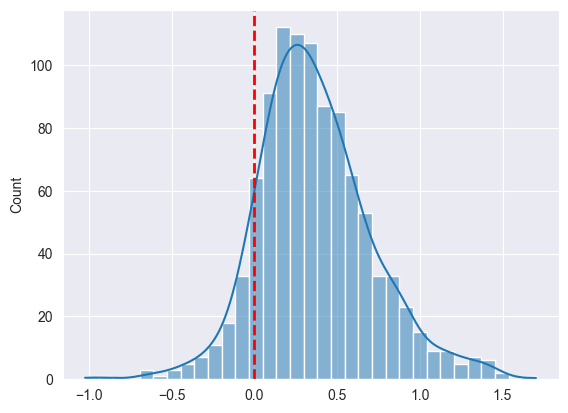

In [72]:
stats, dist = mediation_analysis(data=data, x='Conditioning', m='nps_nociception_pain_wager_2011', y='Rating_diff',
                                 covar=['Age', 'Male'], 
                                 n_boot=1000,
                                 alpha=0.05, seed=42, return_dist=True)
sns.histplot(dist, kde=True)
plt.axvline(0, color='r', linestyle='dashed', linewidth=2)
stats

,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,siips2_extranociceptive_pain_woo_2017 ~ X,-0.011187,0.007053,0.113457,-0.025052,0.002677,No
1,Y ~ siips2_extranociceptive_pain_woo_2017,-43.795151,12.089984,0.000329,-67.561760,-20.028542,Yes
2,Total,3.046240,1.746587,0.081895,-0.387219,6.479698,No
3,Direct,2.572089,1.728255,0.137459,-0.825357,5.969535,No
4,Indirect,0.474151,0.341764,0.104000,-0.007976,1.352142,No


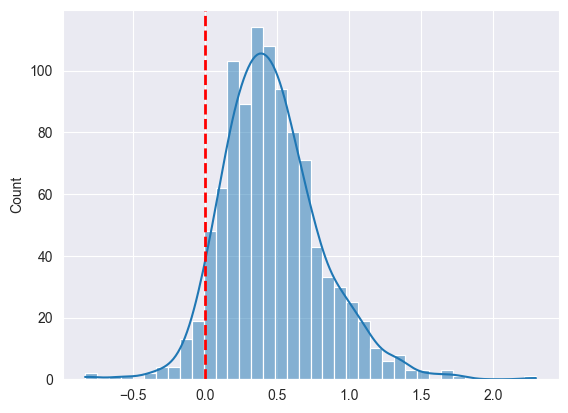

In [71]:
stats, dist = mediation_analysis(data=data, x='Conditioning', m='siips2_extranociceptive_pain_woo_2017', y='Rating_diff',
                                 #covar=['Age', 'Male'], 
                                 alpha=0.05, n_boot=1000, seed=42, return_dist=True)
sns.histplot(dist, kde=True)
plt.axvline(0, color='r', linestyle='dashed', linewidth=2)
stats


In [49]:
dist.shape

(10000,)

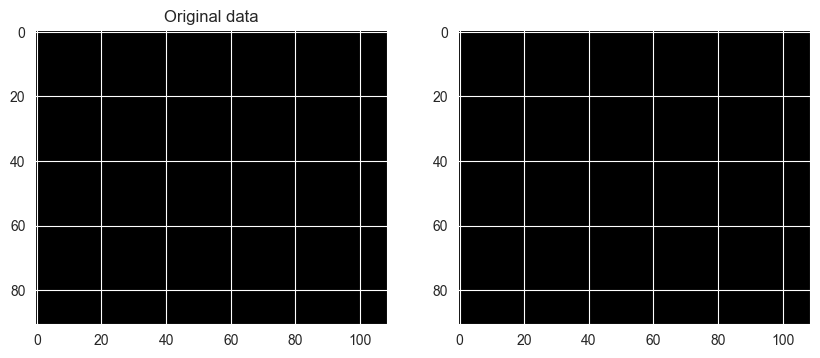

In [102]:
import numpy as np
from scipy.stats import rankdata

# load in a 4d nifti file with nibabel
import nibabel as nib
ranked_diff = nib.load('/Users/tspisak/projects/PIC_conditioning_withinsub_nodatalad/all_data_tranked.nii')
orig_diff = nib.load('/Users/tspisak/projects/PIC_conditioning_withinsub_nodatalad/all_data.nii')
mask = nib.load('/Users/tspisak/projects/PIC_conditioning_withinsub_nodatalad/full_masked_10_percent.nii')

# loop through the 4th dimension and rank the data
orig_data = orig_diff.get_fdata()  # get the data  as a numpy array
ranked_data = ranked_diff.get_fdata()  # get the data  as a numpy array
for i in range(data.shape[-1]):
    vol_orig = orig_data[..., i]
    masked_vol_orig = vol_orig[mask.get_fdata() > 0]
    maxneg, minpos = np.max(masked_vol_orig[masked_vol_orig<=0]), np.min(masked_vol_orig[masked_vol_orig>=0])
   
    vol_ranked = ranked_data[..., i]
    masked_vol_ranked = vol_ranked[mask.get_fdata() > 0]
    
    r0 = np.mean((masked_vol_ranked[masked_vol_orig==maxneg], masked_vol_ranked[masked_vol_orig==minpos]))
    vol_ranked[mask.get_fdata() > 0] = masked_vol_ranked - r0
    
# save the centered ranked data
nib.save(nib.Nifti1Image(ranked_data, ranked_diff.affine, ranked_diff.header), '/Users/tspisak/projects/PIC_conditioning_withinsub_nodatalad/all_data_tranked_centered.nii')


(2.514312744140625, 96453.0)

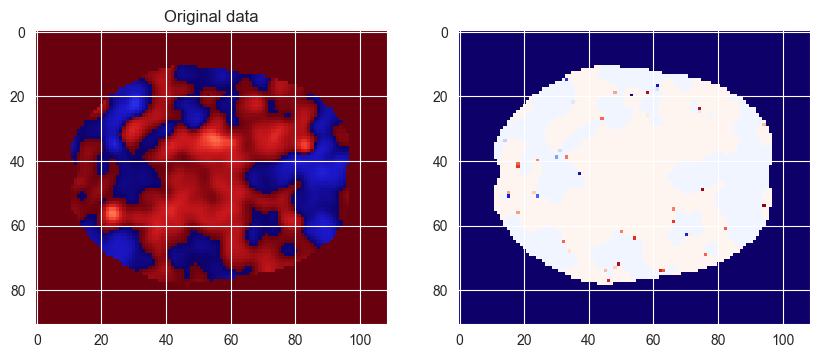

In [117]:
from nilearn.plotting.cm import _cmap_d as nilearn_cmaps
# plot the first volume of both the orig and the ramnked centered data
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(orig_data[..., 0][:, :, 40], cmap=nilearn_cmaps['blue_red'], vmin=-10, vmax=10)
plt.title('Original data')
plt.subplot(1, 2, 2)
plt.imshow(ranked_data[..., 0][:, :, 40], cmap=nilearn_cmaps['blue_red'], vmin=-1000, vmax=1000)

orig_data[58, 26, 41, 0], ranked_data[58, 26, 41, 0]

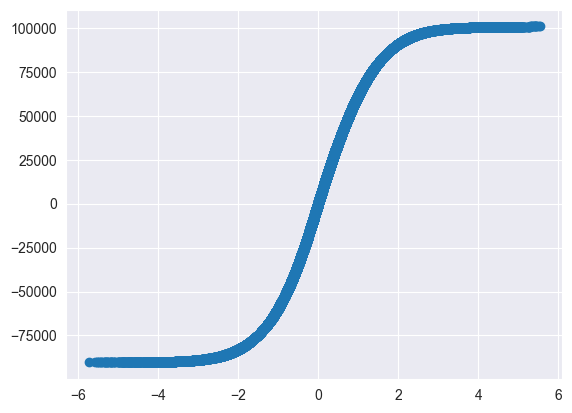

In [118]:
plt.scatter(orig_data[..., 0], ranked_data[..., 0])

In [ ]:
pheno = pd.read_csv(base_dir + '/signatures.csv')